In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt

In [2]:
#LOAD DATA FOR TRAINING

#load excel spreadsheets corresponding to low_dim and high_dim data
# Load the data from Excel files
df_low = pd.read_excel('low_dim.xlsx')
df_high = pd.read_excel('high_dim.xlsx')

# Filter only numeric columns for each dataframe
# Selecting columns with numeric types
numeric_columns_low = df_low.select_dtypes(include=np.number).columns
numeric_columns_high = df_high.select_dtypes(include=np.number).columns

# Keeping only the numeric columns
df_low_numeric = df_low[numeric_columns_low]
df_high_numeric = df_high[numeric_columns_high]

# Convert the filtered DataFrames to NumPy arrays
X_low_dim = df_low_numeric.to_numpy()
X_high_dim = df_high_numeric.to_numpy()

In [3]:
#SET UP FOR PYTORCH

# Convert to PyTorch tensors
X_high_dim_tensor = torch.from_numpy(X_high_dim).float()
X_low_dim_tensor = torch.from_numpy(X_low_dim).float()

# Split the datasets
X_high_train, X_high_val, X_low_train, X_low_val = train_test_split(
    X_high_dim_tensor, X_low_dim_tensor, test_size=0.2, random_state=42)

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_high_train, X_low_train)
val_dataset = TensorDataset(X_high_val, X_low_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [4]:
#INITIALIZE THE NETWORK

import torch.nn as nn
import torch.nn.functional as F

class EmbeddingNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(EmbeddingNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the network
input_dim = X_high_dim.shape[1]
output_dim = 2  # Since you're mapping to a 2D space
model = EmbeddingNet(input_dim, output_dim)


In [5]:
#ONLY RUN ONCE
#TRAIN THE MODEL, TO USE THE MODEL FROM THE PAPER, SKIP THIS STEP

import torch
from torch import nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os

# Assuming model, train_loader, and val_loader are defined elsewhere

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.MSELoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Define the path to save the model parameters on your desktop
external_save_path = r"C:\Users\josep\Desktop\best_model_new.pth"  # Ensure the path is correct and accessible

def train_epoch(model, data_loader, loss_function, optimizer):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in data_loader:
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = loss_function(predictions, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

def validate_epoch(model, data_loader, loss_function):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            predictions = model(X_batch)
            val_loss += loss_function(predictions, y_batch).item()
    return val_loss / len(data_loader)

# Training loop
n_epochs = 10000
patience = 50
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

for epoch in range(n_epochs):
    train_loss = train_epoch(model, train_loader, loss_function, optimizer)
    val_loss = validate_epoch(model, val_loader, loss_function)
    scheduler.step(val_loss)
    
    current_lr = scheduler.optimizer.param_groups[0]['lr']
    
    print(f'Epoch {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Learning Rate: {current_lr:.6f}')
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_model = model.state_dict()
        # Save the best model to your desktop
        torch.save(best_model, external_save_path)
        print(f"Best model saved to {external_save_path}")
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve == patience:
        print("Early stopping!")
        early_stop = True
        break

# Load the best model if early stopping is triggered
if early_stop:
    model.load_state_dict(torch.load(external_save_path))
    print(f"Best model loaded from {external_save_path}")


Epoch 1, Training Loss: 657.3983, Validation Loss: 559.9299, Learning Rate: 0.001000
Best model saved to C:\Users\josep\Desktop\best_model.pth
Epoch 2, Training Loss: 450.5847, Validation Loss: 251.0467, Learning Rate: 0.001000
Best model saved to C:\Users\josep\Desktop\best_model.pth
Epoch 3, Training Loss: 240.0384, Validation Loss: 181.6855, Learning Rate: 0.001000
Best model saved to C:\Users\josep\Desktop\best_model.pth
Epoch 4, Training Loss: 203.8149, Validation Loss: 167.5053, Learning Rate: 0.001000
Best model saved to C:\Users\josep\Desktop\best_model.pth
Epoch 5, Training Loss: 175.8000, Validation Loss: 157.1723, Learning Rate: 0.001000
Best model saved to C:\Users\josep\Desktop\best_model.pth
Epoch 6, Training Loss: 159.5605, Validation Loss: 140.2649, Learning Rate: 0.001000
Best model saved to C:\Users\josep\Desktop\best_model.pth
Epoch 7, Training Loss: 145.8476, Validation Loss: 131.5260, Learning Rate: 0.001000
Best model saved to C:\Users\josep\Desktop\best_model.pth

In [5]:
#LOAD THE MODEL

# Define the path to the saved model on your desktop
model_path = r"C:\Users\josep\Desktop\best_model.pth"

# Load the model parameters from the saved file
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [6]:
#Predict the low-dimensional embeddings for the high-dimensional data using trained model

def predict_low_dim(model, new_high_dim_point):
    high_dim_tensor = torch.from_numpy(new_high_dim_point).float()
    model.eval()
    with torch.no_grad():
        predicted_low_dim = model(high_dim_tensor)
    return predicted_low_dim.numpy()



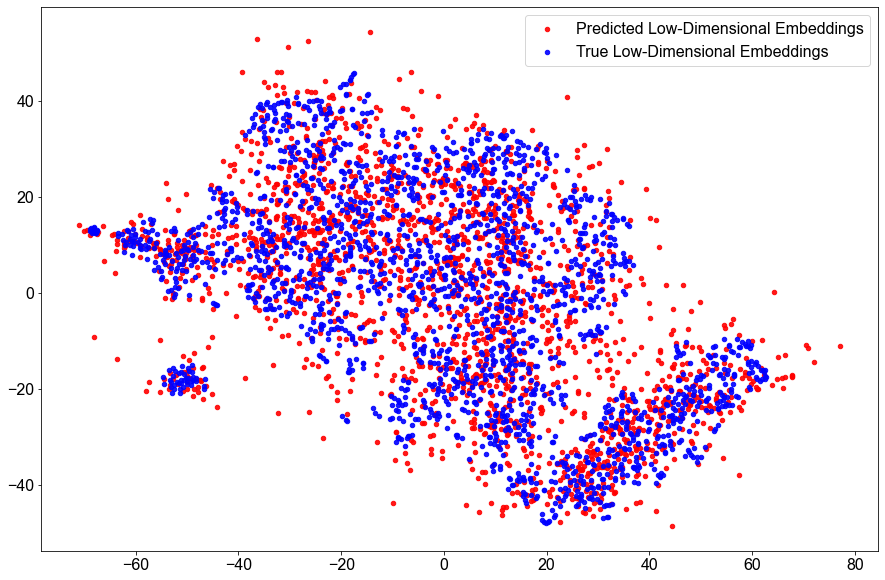

In [10]:
#SHOW TRUE vs. PREDICTED

import matplotlib.pyplot as plt
import numpy as np

# Set the global font and font size settings
plt.rcParams.update({
    'font.size': 16,             # Set the font size for text elements
    'font.family': 'Arial',      # Set the font family to Arial
    'axes.titlesize': 20,        # Font size for the title
    'axes.labelsize': 18,        # Font size for x and y labels
    'xtick.labelsize': 16,       # Font size for x-tick labels
    'ytick.labelsize': 16,       # Font size for y-tick labels
    'legend.fontsize': 16        # Font size for the legend
})

# Assuming X_high_dim, model, predict_low_dim, and X_low_dim are defined elsewhere

# Predict the low-dimensional embeddings for all high-dimensional data points
for i in range(1, len(X_high_dim)):
    newpoint = X_high_dim[i]
    predicted_low_dim = predict_low_dim(model, newpoint)
    # Store predicted low-dimensional embeddings in a new numpy array
    if i == 1:
        predicted_low_dim_all = predicted_low_dim
    else:
        predicted_low_dim_all = np.vstack((predicted_low_dim_all, predicted_low_dim))

# Plot the predicted low-dimensional embeddings
plt.figure(figsize=(15, 10))  # Set the figure size to 15x10
plt.scatter(predicted_low_dim_all[:, 0], predicted_low_dim_all[:, 1], color='red', alpha=0.9, s=20)
plt.scatter(X_low_dim[:, 0], X_low_dim[:, 1], color='blue', alpha=0.9, s=20)

plt.legend(['Predicted Low-Dimensional Embeddings', 'True Low-Dimensional Embeddings'])

# Save the figure as a high-resolution PNG file
plt.savefig('predicted_vs_true_embeddings.png', dpi=300, bbox_inches='tight')  # Save at 300 dpi for high resolution

plt.show()

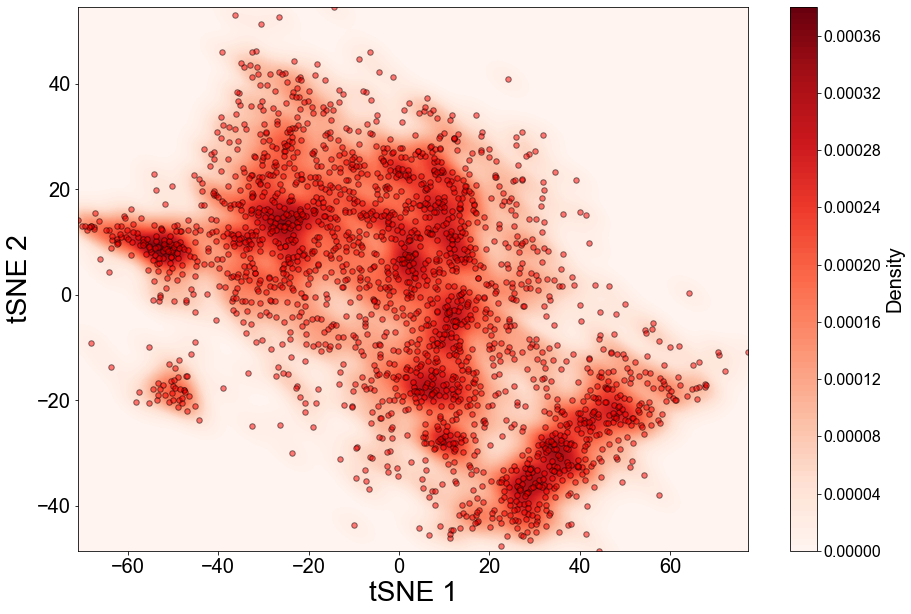

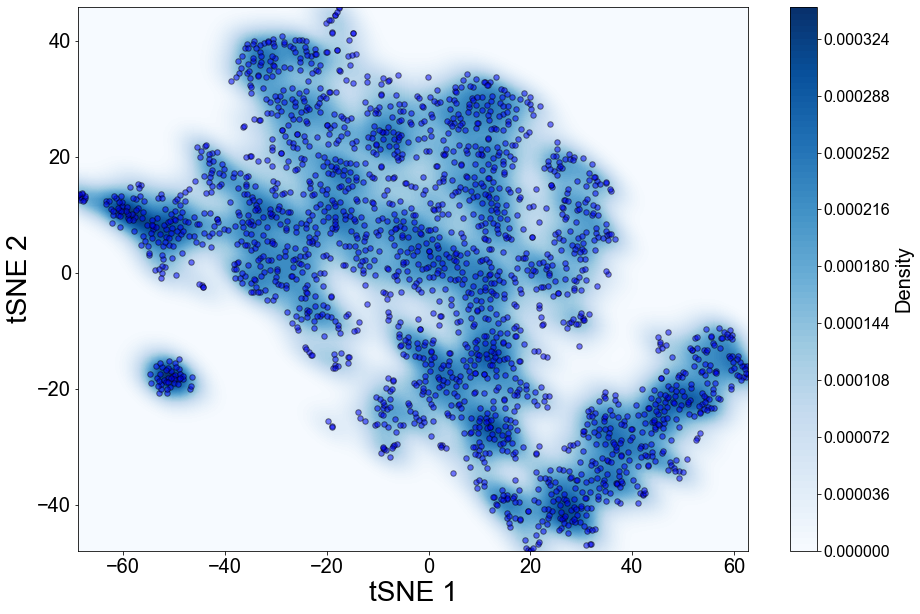

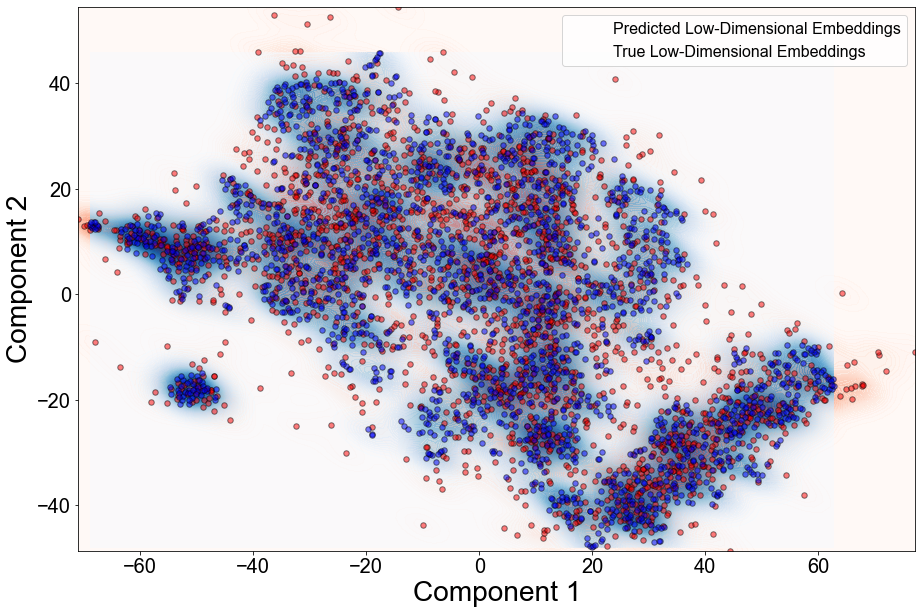

In [11]:
#ANALYZE TRUE vs. PREDICTED

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

# Set the global font and font size settings
plt.rcParams.update({
    'font.size': 16,
    'font.family': 'Arial',
    'axes.titlesize': 20,
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16
})

# Predict the low-dimensional embeddings for all high-dimensional data points
predicted_low_dim_all = np.array([predict_low_dim(model, X_high_dim[i]) for i in range(len(X_high_dim))]).squeeze()

# Function to add KDE to the plot
def plot_with_kde(x, y, color, cmap, title, save_path):
    # Perform KDE
    kde = gaussian_kde(np.vstack([x, y]), bw_method=0.1)
    num_points_x, num_points_y = 100, 100
    X, Y = np.meshgrid(np.linspace(np.min(x), np.max(x), num_points_x), 
                       np.linspace(np.min(y), np.max(y), num_points_y))
    Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

    # Plot the topological surface with KDE
    plt.figure(figsize=(15, 10))
    plt.contourf(X, Y, Z, levels=100, cmap=cmap)
    cbar = plt.colorbar()
    cbar.set_label("Density", fontsize=20, fontname='Arial')
    cbar.ax.tick_params(labelsize=16)

    # Scatter plot of the original points
    plt.scatter(x, y, s=30, color=color, alpha=0.5, edgecolor='k')

    # Set labels and other formatting
    plt.xlabel("tSNE 1", fontsize=28, fontname='Arial')
    plt.ylabel("tSNE 2", fontsize=28, fontname='Arial')
    plt.xticks(fontsize=20, fontname='Arial')
    plt.yticks(fontsize=20, fontname='Arial')
    
    # Save the figure in high resolution
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Plot the predicted low-dimensional embeddings with KDE
plot_with_kde(predicted_low_dim_all[:, 0], predicted_low_dim_all[:, 1], 
              color='red', cmap='Reds', 
              title='Predicted Low-Dimensional Embeddings with KDE', 
              save_path='predicted_embeddings_kde.png')

# Plot the true low-dimensional embeddings with KDE
plot_with_kde(X_low_dim[:, 0], X_low_dim[:, 1], 
              color='blue', cmap='Blues', 
              title='True Low-Dimensional Embeddings with KDE', 
              save_path='true_embeddings_kde.png')

# Plot both predicted and true low-dimensional embeddings with KDE
plt.figure(figsize=(15, 10))

# KDE for predicted
kde_predicted = gaussian_kde(np.vstack([predicted_low_dim_all[:, 0], predicted_low_dim_all[:, 1]]), bw_method=0.1)
X_pred, Y_pred = np.meshgrid(np.linspace(np.min(predicted_low_dim_all[:, 0]), np.max(predicted_low_dim_all[:, 0]), 100),
                             np.linspace(np.min(predicted_low_dim_all[:, 1]), np.max(predicted_low_dim_all[:, 1]), 100))
Z_pred = kde_predicted(np.vstack([X_pred.ravel(), Y_pred.ravel()])).reshape(X_pred.shape)
plt.contourf(X_pred, Y_pred, Z_pred, levels=100, cmap="Reds", alpha=0.5)

# KDE for true
kde_true = gaussian_kde(np.vstack([X_low_dim[:, 0], X_low_dim[:, 1]]), bw_method=0.1)
X_true, Y_true = np.meshgrid(np.linspace(np.min(X_low_dim[:, 0]), np.max(X_low_dim[:, 0]), 100),
                             np.linspace(np.min(X_low_dim[:, 1]), np.max(X_low_dim[:, 1]), 100))
Z_true = kde_true(np.vstack([X_true.ravel(), Y_true.ravel()])).reshape(X_true.shape)
plt.contourf(X_true, Y_true, Z_true, levels=100, cmap="Blues", alpha=0.5)

# Scatter plots of predicted and true embeddings
plt.scatter(predicted_low_dim_all[:, 0], predicted_low_dim_all[:, 1], color='red', alpha=0.5, s=30, edgecolor='k')
plt.scatter(X_low_dim[:, 0], X_low_dim[:, 1], color='blue', alpha=0.5, s=30, edgecolor='k')
plt.legend(['Predicted Low-Dimensional Embeddings', 'True Low-Dimensional Embeddings'], fontsize=16)
plt.xlabel("Component 1", fontsize=28, fontname='Arial')
plt.ylabel("Component 2", fontsize=28, fontname='Arial')
plt.xticks(fontsize=20, fontname='Arial')
plt.yticks(fontsize=20, fontname='Arial')

# Save the combined KDE plot
plt.savefig('predicted_vs_true_embeddings_kde.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
#QUANTIFY SIMILARITY

import numpy as np
from scipy.stats import gaussian_kde, pearsonr
from skimage.metrics import structural_similarity as ssim

# Generate KDE surfaces
def compute_kde_surface(x, y):
    kde = gaussian_kde(np.vstack([x, y]), bw_method=0.1)
    num_points = 100
    X, Y = np.meshgrid(np.linspace(np.min(x), np.max(x), num_points),
                       np.linspace(np.min(y), np.max(y), num_points))
    Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)
    return Z

# Compute KDE surfaces
Z_pred = compute_kde_surface(predicted_low_dim_all[:, 0], predicted_low_dim_all[:, 1])
Z_true = compute_kde_surface(X_low_dim[:, 0], X_low_dim[:, 1])


#Jensen-Shannon Divergence (JSD)
def jensen_shannon_divergence(p, q):
    # Normalize the density to sum to 1
    p = p / p.sum()
    q = q / q.sum()
    m = 0.5 * (p + q)
    jsd = 0.5 * (np.sum(p * np.log(p / m + 1e-10)) + np.sum(q * np.log(q / m + 1e-10)))
    return jsd

jsd_value = jensen_shannon_divergence(Z_pred, Z_true)
print(f"Jensen-Shannon Divergence (JSD): {jsd_value:.4f}")

Jensen-Shannon Divergence (JSD): 0.0943


In [15]:
#LOAD SIMULATED COLONIES

import pandas as pd
import os

# Define the folder path
folder_path = 'Simulated Colonies 4'

# Column names for the final DataFrame
column_names = ['GATA' + str(i) for i in range(1, 50)] + \
               ['BRA' + str(i) for i in range(1, 50)] + \
               ['SOX' + str(i) for i in range(1, 50)]

# Initialize an empty DataFrame
combined_df = pd.DataFrame(columns=column_names)

# Iterate through each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.xlsx'):
        file_path = os.path.join(folder_path, filename)
        
        # Read the Excel file
        df = pd.read_excel(file_path)

        # Data cleaning and transformation
        df = df.drop(df[df['Bin'] == 1].index)  # Drop the row with Bin 1
        transposed_df = df.set_index('Bin').T   # Transpose the DataFrame

        # Reshape and align the data with the column names
        reshaped_data = transposed_df.values.flatten()
        
        # Create a row for the combined DataFrame
        row_df = pd.DataFrame([reshaped_data], columns=column_names, index=[filename.replace('.xlsx', '')])

        # Append to the combined DataFrame
        combined_df = pd.concat([combined_df, row_df])

# Save the combined DataFrame to a new Excel file
combined_df.to_excel('combined_data4.xlsx')

print("Data combined and saved successfully.")


Data combined and saved successfully.


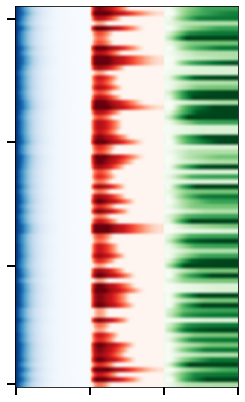

In [16]:
#VIZUALIZE SIMULATED COLONIES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the combined DataFrame
combined_df = pd.read_excel('combined_data4.xlsx', index_col=0)

# Shuffle the indices randomly
shuffled_df = combined_df.sample(frac=1).reset_index(drop=True)

# Define the correct ranges based on column names
GATA_columns = [col for col in shuffled_df.columns if 'GATA' in col]
BRA_columns = [col for col in shuffled_df.columns if 'BRA' in col]
SOX_columns = [col for col in shuffled_df.columns if 'SOX' in col]

GATA_range1 = shuffled_df[GATA_columns]
BRA_range1 = shuffled_df[BRA_columns]
SOX_range1 = shuffled_df[SOX_columns]

# Normalize each range to the 75th and 25th percentiles
def normalize_range(data):
    lower = data.quantile(0.25).min()
    upper = data.quantile(0.75).max()
    return (data - lower) / (upper - lower)

GATA_matrix = normalize_range(GATA_range1)
BRA_matrix = normalize_range(BRA_range1)
SOX_matrix = normalize_range(SOX_range1)

# Apply colormaps without clipping
GATA_colors = plt.cm.Blues(GATA_matrix)
BRA_colors = plt.cm.Reds(BRA_matrix)
SOX_colors = plt.cm.Greens(SOX_matrix)

# Combine the color matrices along the features axis
combined_colors = np.concatenate((GATA_colors, BRA_colors, SOX_colors), axis=1)

# Set the font to Arial
plt.rcParams['font.family'] = 'Arial'

# Plot the image
fig, ax = plt.subplots(figsize=(4, 7))
ax.imshow(combined_colors, aspect='auto')
ax.invert_yaxis()

# Update xticks and yticks
num_gata = len(GATA_columns)
num_bra = len(BRA_columns)
num_sox = len(SOX_columns)
xticks = [0, num_gata, num_gata + num_bra, num_gata + num_bra + num_sox]
yticks = [0, 24, 49, 74]

ax.set_xticks(xticks)
ax.set_xticklabels([])  # Remove x-tick labels
ax.set_yticks(yticks)
ax.set_yticklabels([])  # Remove y-tick labels

# Increase the thickness of the tick marks
ax.tick_params(axis='both', which='both', length=8, width=2)  # Adjust 'length' and 'width' as needed

# Save the figure as a high-resolution image
plt.savefig('High_dimensional_data_viz.png', dpi=600, bbox_inches='tight')

plt.show()

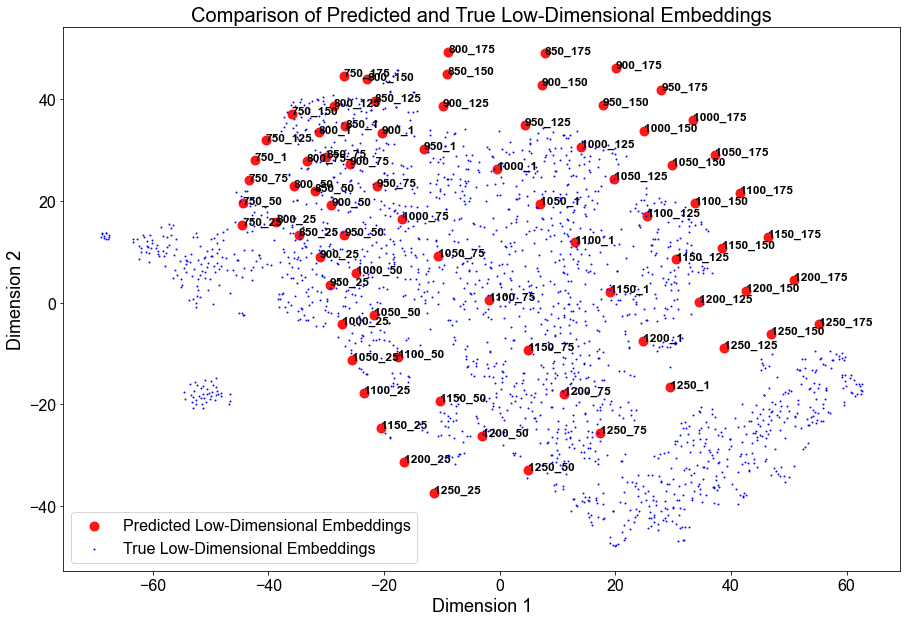

In [18]:
#SHOW PREDICTED EMBEDDING OF SIMULATED COLONIES

# Load the new data from "combined_data.xlsx" and set the first column as the index
df_combined = pd.read_excel('combined_data4.xlsx', index_col=0)

# Extract the relevant part of the index
df_combined['index_label'] = df_combined.index.to_series().astype(str).str.extract('Average_Intensities_(.*)')[0]

# Assuming the data structure is similar to high_dim.xlsx, filter only numeric columns
numeric_columns_combined = df_combined.select_dtypes(include=np.number).columns
df_combined_numeric = df_combined[numeric_columns_combined]

# Convert the DataFrame to a NumPy array
X_combined = df_combined_numeric.to_numpy()

# Predict the low-dimensional embeddings for the new data
predicted_combined_low_dim = []
for i in range(len(X_combined)):
    newpoint = X_combined[i]
    predicted_low_dim = predict_low_dim(model, newpoint)
    predicted_combined_low_dim.append(predicted_low_dim)

predicted_combined_low_dim = np.vstack(predicted_combined_low_dim)

# Plot the predicted low-dimensional embeddings along with the original ones
plt.figure(figsize=(15, 10))  # Set the figure size to 15x10 inches

# Plot all predicted points in one go
plt.scatter(predicted_combined_low_dim[:, 0], predicted_combined_low_dim[:, 1], color='red', alpha=0.9, s=80, label='Predicted Low-Dimensional Embeddings')

# Add bold text labels
for i in range(len(predicted_combined_low_dim)):
    plt.text(predicted_combined_low_dim[i, 0], predicted_combined_low_dim[i, 1], df_combined['index_label'][i], fontsize=12, fontweight='bold')

# Plot the true low-dimensional embeddings
plt.scatter(X_low_dim[:, 0], X_low_dim[:, 1], color='blue', alpha=0.9, s=1, label='True Low-Dimensional Embeddings')

plt.legend()
plt.title('Comparison of Predicted and True Low-Dimensional Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.savefig('morphospace.png', bbox_inches='tight')
plt.show()

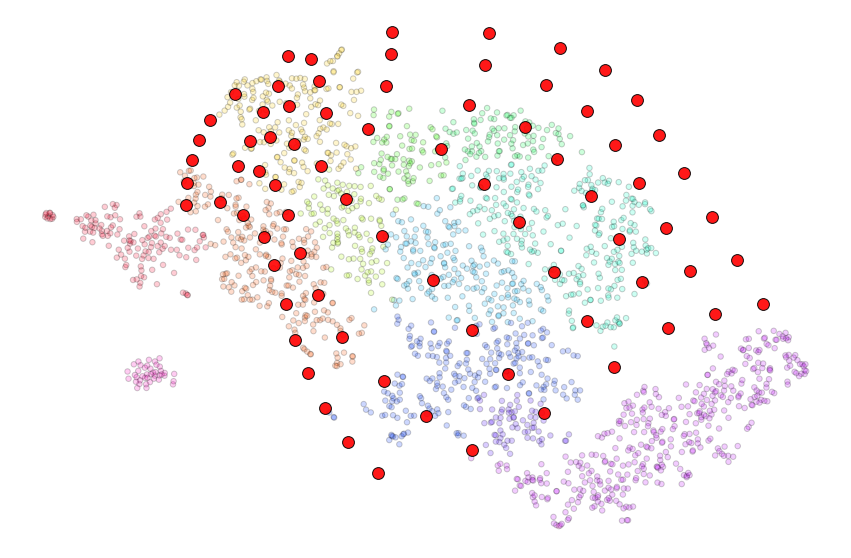

In [21]:
#SHOW PREDICTED EMBEDDING OF SIMULATED COLONIES (COLORED)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Load the combined data
df_combined = pd.read_excel('combined_data4.xlsx', index_col=0)

# Extract the relevant part of the index
df_combined['index_label'] = df_combined.index.to_series().astype(str).str.extract('Average_Intensities_(.*)')[0]

# Filter only numeric columns
numeric_columns_combined = df_combined.select_dtypes(include=np.number).columns
df_combined_numeric = df_combined[numeric_columns_combined]

# Convert the DataFrame to a NumPy array
X_combined = df_combined_numeric.to_numpy()

# Predict the low-dimensional embeddings for the new data
predicted_combined_low_dim = []
for i in range(len(X_combined)):
    newpoint = X_combined[i]
    predicted_low_dim = predict_low_dim(model, newpoint)
    predicted_combined_low_dim.append(predicted_low_dim)

predicted_combined_low_dim = np.vstack(predicted_combined_low_dim)

# Load the workbook containing point labels
df_labels = pd.read_excel('point_labels.xlsx')

# Create a color map based on point labels
cmap = plt.cm.gist_rainbow
norm = mcolors.Normalize(vmin=np.min(df_labels['Point_Label']), vmax=np.max(df_labels['Point_Label']))
colors = cmap(norm(df_labels['Point_Label'].values))



plt.figure(figsize=(15, 10))  # Set the figure size to 15x10 inches

# Plot the true low-dimensional embeddings with the corresponding colors
plt.scatter(X_low_dim[:, 0], X_low_dim[:, 1], color=colors, edgecolors='black', s=30, alpha=0.2)

# Plot the predicted low-dimensional embeddings
plt.scatter(predicted_combined_low_dim[:, 0], predicted_combined_low_dim[:, 1], color='red', edgecolors='black', alpha=0.9, s=140, label='Predicted Low-Dimensional Embeddings')

# Remove all axes, labels, and titles
plt.axis('off')

plt.savefig('morphospace.png', bbox_inches='tight', dpi=300)  # Save as high-resolution image
plt.show()

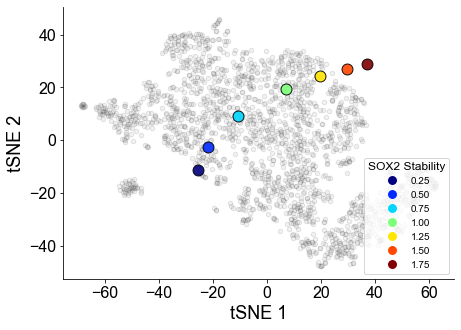

In [31]:
# SHOW IMPACT OF SOX2 STABILITY at CONSTANT CELL DENSITY (1050 cells)

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Set font properties to match the desired style
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],  # Change to your desired font, e.g., 'Arial'
    'font.size': 12
})

def plot_grouped_data_specific_labels(labels_to_plot):
    # Filter data to only include the specific labels
    labels_to_plot_str = [f'1050_{label}' for label in labels_to_plot]
    group_mask = df_combined['index_label'].isin(labels_to_plot_str)
    group_data = predicted_combined_low_dim[group_mask]
    
    # Generate colors for the labels
    cmap = plt.get_cmap('jet')
    colors = cmap(np.linspace(0, 1, len(labels_to_plot)))
    
    plt.figure(figsize=(7, 5))  # Set the figure size to 7x5 inches

    # Plot all points in grey with black edges
    plt.scatter(X_low_dim[:, 0], X_low_dim[:, 1], color='grey', edgecolors='black', s=20, alpha=0.1)

    # Plot all predicted points for each label with corresponding colors
    for label, color in zip(labels_to_plot, colors):
        label_str = f'1050_{label}'
        group_mask = df_combined['index_label'] == label_str
        group_data = predicted_combined_low_dim[group_mask]
        plt.scatter(group_data[:, 0], group_data[:, 1], color=color, edgecolors='black', alpha=0.9, s=120)

    # Remove top and right spines
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    plt.xlabel('tSNE 1')
    plt.ylabel('tSNE 2')

    # Create a mapping from numeric labels to formatted strings
    label_mapping = {
        25: '0.25', 50: '0.50', 75: '0.75', 1: '1.00',
        125: '1.25', 150: '1.50', 175: '1.75'
    }

    # Create legend handles and use the formatted labels
    legend_handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=label_mapping[labels_to_plot[i]])
        for i in range(len(labels_to_plot))
    ]
    
    # Add the legend, positioned in the lower right
    ax.legend(handles=legend_handles, loc='lower right', fontsize=10, title="SOX2 Stability")

    # Save the plot with high resolution
    plt.savefig('Predicted_Embeddings_Specific_Labels.png', bbox_inches='tight', dpi=600)
    plt.savefig('Predicted_Embeddings_Specific_Labels.svg', bbox_inches='tight')
    plt.show()

    return labels_to_plot, colors

# Labels to plot
labels_to_plot = [25, 50, 75, 1, 125, 150, 175]

# Plot and save only for the specific labels
custom_labels, sorted_colors = plot_grouped_data_specific_labels(labels_to_plot)

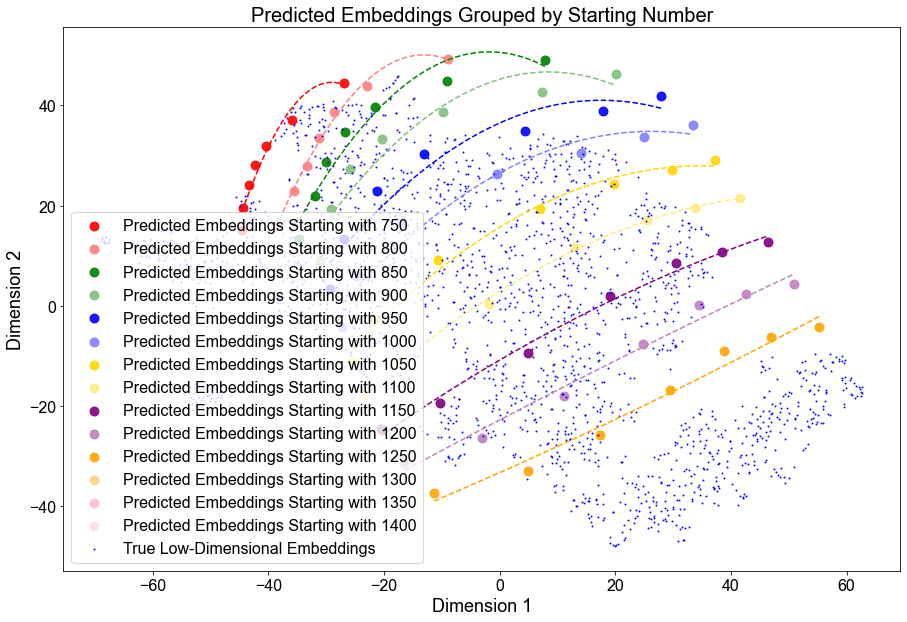

Polynomial coefficients saved to 'polynomial_coefficients.csv'


In [32]:
#SHOW ALL DENSITY VALUES AND FIT POLYNOMIALS

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from numpy.polynomial.polynomial import Polynomial

# Define the base color map for different groups
base_color_map = {750: 'red', 850: 'green', 950: 'blue', 1050: 'gold', 1150: 'purple', 1250: 'orange', 1350: 'pink'}

# Function to lighten a color
def lighten_color(color, amount=0.5):
    try:
        c = mcolors.cnames[color]
    except KeyError:
        c = color
    c = mcolors.to_rgba(c)
    return mcolors.to_rgba((c[0] + amount * (1.0 - c[0]),
                            c[1] + amount * (1.0 - c[1]),
                            c[2] + amount * (1.0 - c[2])))

# Extended color map to include lighter versions
extended_color_map = {}
for base_number, color in base_color_map.items():
    extended_color_map[base_number] = color
    lighter_color = lighten_color(color, amount=0.5)
    extended_color_map[base_number + 50] = lighter_color

plt.figure(figsize=(15, 10))  # Set the figure size to 15x10 inches

# DataFrame to store polynomial coefficients
poly_coefficients = pd.DataFrame(columns=['Group', 'Coefficient_0', 'Coefficient_1', 'Coefficient_2'])

# Plot each group with a specific color and add polynomial fit lines
for number in extended_color_map.keys():
    group_mask = df_combined['index_label'].str.startswith(str(number))
    group_data = predicted_combined_low_dim[group_mask]
    
    # Scatter plot for the group
    plt.scatter(group_data[:, 0], group_data[:, 1], color=extended_color_map[number], alpha=0.9, s=80, label=f'Predicted Embeddings Starting with {number}')
    
    # Fit a polynomial of degree 2 (quadratic) to the data
    if len(group_data) > 2:  # Ensure there are enough points to fit the polynomial
        p = Polynomial.fit(group_data[:, 0], group_data[:, 1], deg=2)
        x_fit = np.linspace(min(group_data[:, 0]), max(group_data[:, 0]), 100)
        y_fit = p(x_fit)
        plt.plot(x_fit, y_fit, color=extended_color_map[number], linestyle='--')
        
        # Save polynomial coefficients to the DataFrame
        coeffs = p.convert().coef
        poly_coefficients = poly_coefficients.append({'Group': number, 
                                                      'Coefficient_0': coeffs[0], 
                                                      'Coefficient_1': coeffs[1], 
                                                      'Coefficient_2': coeffs[2]}, ignore_index=True)

# Plot the true low-dimensional embeddings
plt.scatter(X_low_dim[:, 0], X_low_dim[:, 1], color='blue', alpha=0.9, s=1, label='True Low-Dimensional Embeddings')

plt.legend()
plt.title('Predicted Embeddings Grouped by Starting Number')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.savefig('Predicted_Embeddings_Grouped_by_Starting_Number.png', bbox_inches='tight')
plt.show()

# Save the polynomial coefficients DataFrame
poly_coefficients.to_csv('polynomial_coefficients.csv', index=False)
print("Polynomial coefficients saved to 'polynomial_coefficients.csv'")


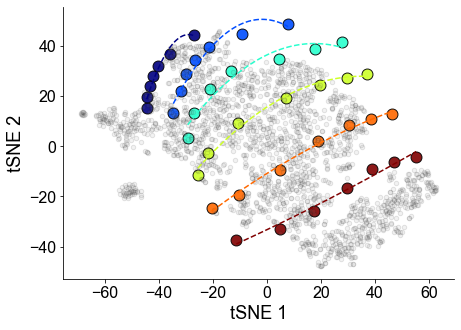

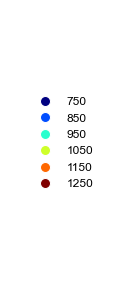

In [33]:
# VIEW 750, 850, 950, 1050, 1150, and 1250 cells

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from numpy.polynomial.polynomial import Polynomial

# Set font properties to Arial and increase resolution
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 12,
    'savefig.dpi': 300  # High resolution for saving figures
})

# Define the starting numbers to plot
starting_numbers = [750, 850, 950, 1050, 1150, 1250]

# Generate colors for the starting numbers using the 'jet' colormap
cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0, 1, len(starting_numbers)))
color_map = dict(zip(starting_numbers, colors))

plt.figure(figsize=(7, 5))  # Set the figure size to 7x5 inches

# DataFrame to store polynomial coefficients
poly_coefficients = pd.DataFrame(columns=['Group', 'Coefficient_0', 'Coefficient_1', 'Coefficient_2'])

# Plot each group with a specific color and add polynomial fit lines
for number in color_map.keys():
    group_mask = df_combined['index_label'].str.startswith(str(number))
    group_data = predicted_combined_low_dim[group_mask]

    # Scatter plot for the group
    plt.scatter(group_data[:, 0], group_data[:, 1], color=color_map[number], alpha=0.9, s=120, edgecolors='black')

    # Fit a polynomial of degree 2 (quadratic) to the data
    if len(group_data) > 2:  # Ensure there are enough points to fit the polynomial
        p = Polynomial.fit(group_data[:, 0], group_data[:, 1], deg=2)
        x_fit = np.linspace(min(group_data[:, 0]), max(group_data[:, 0]), 100)
        y_fit = p(x_fit)
        plt.plot(x_fit, y_fit, color=color_map[number], linestyle='--')

        # Save polynomial coefficients to the DataFrame
        coeffs = p.convert().coef
        poly_coefficients = poly_coefficients.append({'Group': number, 
                                                      'Coefficient_0': coeffs[0], 
                                                      'Coefficient_1': coeffs[1], 
                                                      'Coefficient_2': coeffs[2]}, ignore_index=True)

# Plot the true low-dimensional embeddings
plt.scatter(X_low_dim[:, 0], X_low_dim[:, 1], color='grey', alpha=0.1, s=20, edgecolors='black')

# Remove top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.xlabel('tSNE 1')
plt.ylabel('tSNE 2')

# Save the plot with high resolution
plt.savefig('Predicted_Embeddings_Grouped_by_Starting_Number.png', bbox_inches='tight', dpi=300)
plt.show()

# Create a separate plot for the legend
def plot_legend(color_map):
    fig, ax = plt.subplots(figsize=(2, 5))

    # Custom legend handles using circles for each color and labels for starting numbers
    legend_handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[key], markersize=10, label=str(key))
        for key in color_map if key in starting_numbers
    ]

    # Add the custom legend circles to the legend with labels
    ax.legend(handles=legend_handles, loc='center', fontsize=12, frameon=False)
    ax.axis('off')

    # Save the legend with high resolution
    plt.savefig('legend_plot.png', bbox_inches='tight', dpi=300)
    plt.show()

# Plot the legend
plot_legend(color_map)

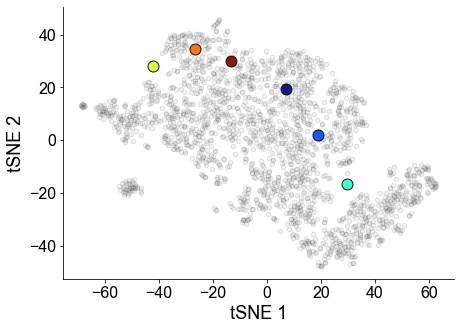

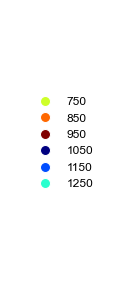

In [34]:
# SHOW IMPACTS OF VARYING CELL DENSITY AT CONSTANT SOX2 STABILITY (Cs = 1)

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Set font properties to Arial and increase resolution
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 12,
    'savefig.dpi': 300  # High resolution for saving figures
})

def plot_grouped_data_ending(ending_number):
    group_mask = df_combined['index_label'].str.endswith(f'_{ending_number}')
    group_data = predicted_combined_low_dim[group_mask]
    
    # Extract the first numbers for legend labels
    full_labels = df_combined['index_label'][group_mask]
    labels = full_labels.str.split('_').str[0].astype(int)
    
    # Filter to only include specific labels
    desired_labels = [750, 850, 950, 1050, 1150, 1250]
    filter_mask = labels.isin(desired_labels)
    filtered_group_data = group_data[filter_mask]
    filtered_labels = labels[filter_mask]
    
    # Generate colors for the group data points
    cmap = plt.get_cmap('jet')
    num_points = filtered_group_data.shape[0]
    colors = cmap(np.linspace(0, 1, num_points))
    
    plt.figure(figsize=(7, 5))  # Set the figure size to 7x5 inches

    # Plot all points in grey with black edges
    plt.scatter(X_low_dim[:, 0], X_low_dim[:, 1], color='grey', edgecolors='black', s=20, alpha=0.1)

    # Plot all predicted points for the group with different colors
    for i, color in enumerate(colors):
        plt.scatter(filtered_group_data[i, 0], filtered_group_data[i, 1], color=color, edgecolors='black', alpha=0.9, s=120)  # Change point size to 120

    # Remove top and right spines
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    plt.xlabel('tSNE 1')
    plt.ylabel('tSNE 2')

    # Save the plot with high resolution
    plt.savefig(f'Predicted_Embeddings_Ending_with_{ending_number}.png', bbox_inches='tight', dpi=300)
    plt.show()

    return filtered_labels.values, colors

# Initialize lists to store labels and colors for the legend
all_labels = []
all_colors = []

# Plot and save for each ending number
for number in [1]:  # Modify to only process '_1' ending as an example
    labels, colors = plot_grouped_data_ending(number)
    all_labels.extend(labels)
    all_colors.extend(colors[:len(labels)])  # Ensure colors list matches the length of labels

# Sort the labels and colors
sorted_indices = np.argsort(all_labels)
sorted_labels = np.array(all_labels)[sorted_indices]
sorted_colors = np.array(all_colors)[sorted_indices]

# Create a separate plot for the legend using circles for each color
def plot_legend(labels, colors):
    fig, ax = plt.subplots(figsize=(2, 5))

    # Use .get() to avoid KeyError and return the label itself if not found in mapping
    label_mapping = {
        25: '0.25', 50: '0.50', 75: '0.75', 1: '1.00', 
        125: '1.25', 150: '1.50', 175: '1.75'
    }
    
    transformed_labels = [label_mapping.get(label, str(label)) for label in labels]

    # Custom legend handles using circles for each color
    legend_handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10) 
        for i in range(len(transformed_labels))
    ]

    # Add the custom legend circles to the legend
    ax.legend(handles=legend_handles, labels=transformed_labels, loc='center', fontsize=12, frameon=False)
    ax.axis('off')

    # Save the legend with high resolution
    plt.savefig('legend_plot.png', bbox_inches='tight', dpi=300)
    plt.show()

# Plot the legend
plot_legend(sorted_labels, sorted_colors)

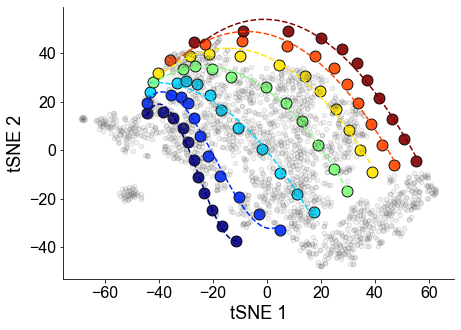

Polynomial coefficients for ending numbers saved to 'polynomial_coefficients_ending.csv'


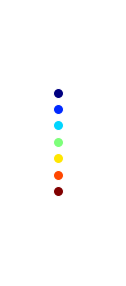

In [35]:
#SHOW ALL VALUES AND FIT POLYNOMIALS

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from numpy.polynomial.polynomial import Polynomial

# Set font properties to Arial and increase resolution
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 12,
    'savefig.dpi': 300  # High resolution for saving figures
})

# Define the ending numbers to plot
ending_numbers = [25, 50, 75, 1, 125, 150, 175]

# Generate colors for the ending numbers using the 'jet' colormap
cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0, 1, len(ending_numbers)))
color_map = dict(zip(ending_numbers, colors))

# Define a degree map to select polynomial degrees
degree_map = {25: 3, 50: 3, 75: 2, 125: 2, 150: 2, 175: 2, 1: 2}

plt.figure(figsize=(7, 5))  # Set the figure size to 7x5 inches

# DataFrame to store polynomial coefficients
poly_coefficients_ending = pd.DataFrame(columns=['Group', 'Degree', 'Coefficient_0', 'Coefficient_1', 'Coefficient_2', 'Coefficient_3'])

# Plot each group with a specific color based on ending number and add polynomial fit lines
for number in color_map.keys():
    group_mask = df_combined['index_label'].str.endswith(f'_{number}')
    group_data = predicted_combined_low_dim[group_mask]

    # Scatter plot for the group
    plt.scatter(group_data[:, 0], group_data[:, 1], color=color_map[number], alpha=0.9, s=120, edgecolors='black')

    # Fit a polynomial of specified degree to the data
    degree = degree_map.get(number, 2)  # Default to 2 if not in the map
    if len(group_data) > degree:  # Ensure there are enough points to fit the polynomial
        p = Polynomial.fit(group_data[:, 0], group_data[:, 1], deg=degree)
        x_fit = np.linspace(min(group_data[:, 0]), max(group_data[:, 0]), 100)
        y_fit = p(x_fit)
        plt.plot(x_fit, y_fit, color=color_map[number], linestyle='--')

        # Save polynomial coefficients to the DataFrame
        coeffs = p.convert().coef
        poly_coefficients_ending = poly_coefficients_ending.append({
            'Group': number, 
            'Degree': degree,
            'Coefficient_0': coeffs[0], 
            'Coefficient_1': coeffs[1], 
            'Coefficient_2': coeffs[2] if len(coeffs) > 2 else np.nan, 
            'Coefficient_3': coeffs[3] if len(coeffs) > 3 else np.nan
        }, ignore_index=True)

# Plot the true low-dimensional embeddings
plt.scatter(X_low_dim[:, 0], X_low_dim[:, 1], color='grey', alpha=0.1, s=20, edgecolors='black')

# Remove top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.xlabel('tSNE 1')
plt.ylabel('tSNE 2')

# Save the plot with high resolution
plt.savefig('Predicted_Embeddings_Grouped_by_Ending_Number.png', bbox_inches='tight', dpi=300)
plt.show()

# Save the polynomial coefficients DataFrame
poly_coefficients_ending.to_csv('polynomial_coefficients_ending.csv', index=False)
print("Polynomial coefficients for ending numbers saved to 'polynomial_coefficients_ending.csv'")

# Create a separate plot for the legend
def plot_legend(color_map):
    fig, ax = plt.subplots(figsize=(2, 5))

    # Custom legend handles using circles for each color
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[key], markersize=10) for key in color_map]

    # Add the custom legend circles to the legend
    ax.legend(handles=legend_handles, loc='center', fontsize=12, frameon=False)
    ax.axis('off')

    # Save the legend with high resolution
    plt.savefig('legend_plot.png', bbox_inches='tight', dpi=300)
    plt.show()

# Plot the legend
plot_legend(color_map)


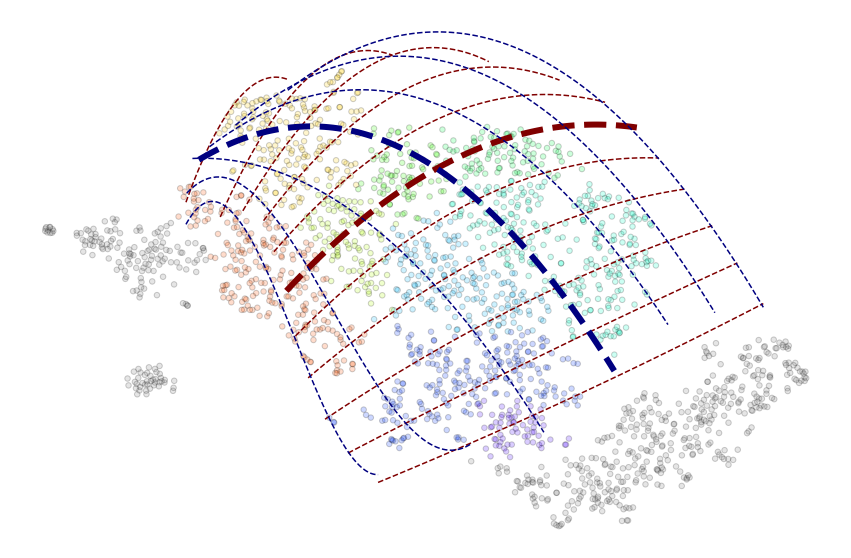

In [36]:
#SHOW ALL AXES (FIT POLYNOMIALS)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from numpy.polynomial.polynomial import Polynomial

# Load the workbook containing point labels
df_labels = pd.read_excel('point_labels.xlsx')

# Create a color map based on point labels
cmap = plt.cm.gist_rainbow
norm = mcolors.Normalize(vmin=np.min(df_labels['Point_Label']), vmax=np.max(df_labels['Point_Label']))
colors = cmap(norm(df_labels['Point_Label'].values))

# Apply gray color and lower alpha to specific labels
transparency_mask = np.isin(df_labels['Point_Label'], [1, 11, 12])
colors[transparency_mask] = np.array([0.5, 0.5, 0.5, 0.1])  # Grey and very transparent

plt.figure(figsize=(15, 10))  # Set the figure size

# Plot the true low-dimensional embeddings with corresponding colors
plt.scatter(X_low_dim[:, 0], X_low_dim[:, 1], color=colors, edgecolors='black', s=30, alpha=0.2)

# Load polynomial coefficients for starting and ending groups
poly_coefficients_starting = pd.read_csv('polynomial_coefficients.csv')
poly_coefficients_ending = pd.read_csv('polynomial_coefficients_ending.csv')

# Degree map for ending polynomials
degree_map = {25: 3, 50: 3, 75: 2, 125: 2, 150: 2, 175: 2, 1: 2}

# Plot starting group polynomials
for _, row in poly_coefficients_starting.iterrows():
    group_number = int(row['Group'])
    coeffs = [row['Coefficient_0'], row['Coefficient_1'], row['Coefficient_2']]
    p = Polynomial(coeffs)
    
    group_mask = df_combined['index_label'].str.startswith(str(group_number))
    group_data = predicted_combined_low_dim[group_mask]

    if len(group_data) > 0:
        x_fit = np.linspace(min(group_data[:, 0]), max(group_data[:, 0]), 100)
        y_fit = p(x_fit)
        if group_number == 1000:
            plt.plot(x_fit, y_fit, color='maroon', linestyle='--', linewidth=6, 
                     label=f'Starting with {group_number}' if f'Starting with {group_number}' not in plt.gca().get_legend_handles_labels()[1] else "")
        else:
            plt.plot(x_fit, y_fit, color='maroon', linestyle='--', 
                     label=f'Starting with {group_number}' if f'Starting with {group_number}' not in plt.gca().get_legend_handles_labels()[1] else "")

# Plot ending group polynomials
for _, row in poly_coefficients_ending.iterrows():
    group_number = int(row['Group'])
    degree = degree_map.get(group_number, 2)
    coeffs = [row.get(f'Coefficient_{i}', 0) for i in range(degree + 1)]
    p = Polynomial(coeffs)
    
    group_mask = df_combined['index_label'].str.endswith(f'_{group_number}')
    group_data = predicted_combined_low_dim[group_mask]

    if len(group_data) > 0:
        x_fit = np.linspace(min(group_data[:, 0]), max(group_data[:, 0]), 100)
        y_fit = p(x_fit)
        if group_number == 1:
            plt.plot(x_fit, y_fit, color='navy', linestyle='--', linewidth=6, 
                     label=f'Ending with _{group_number}' if f'Ending with _{group_number}' not in plt.gca().get_legend_handles_labels()[1] else "")
        else:
            plt.plot(x_fit, y_fit, color='navy', linestyle='--', 
                     label=f'Ending with _{group_number}' if f'Ending with _{group_number}' not in plt.gca().get_legend_handles_labels()[1] else "")

# Remove axes for a cleaner look
plt.gca().axis('off')

# Save the plot with high resolution
plt.savefig('Overlay_Polynomial_Fit_Lines.png', bbox_inches='tight', dpi=300)
plt.show()


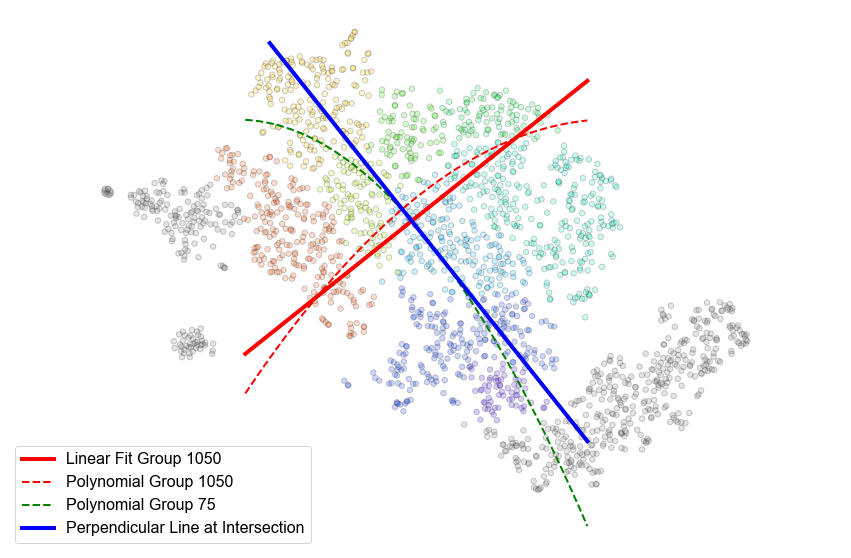

In [37]:
#SHOW LINEARIZED AXES

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from numpy.polynomial.polynomial import Polynomial

# Load the data files
df_labels = pd.read_excel('point_labels.xlsx')
poly_coefficients_starting = pd.read_csv('polynomial_coefficients.csv')
poly_coefficients_ending = pd.read_csv('polynomial_coefficients_ending.csv')

# Step 1: Plotting scatter plot with the linear fit for Group 1050
plt.figure(figsize=(15, 10))
cmap = plt.cm.gist_rainbow
norm = mcolors.Normalize(vmin=np.min(df_labels['Point_Label']), vmax=np.max(df_labels['Point_Label']))
colors = cmap(norm(df_labels['Point_Label'].values))
transparency_mask = np.isin(df_labels['Point_Label'], [1, 11, 12])
colors[transparency_mask] = np.array([0.5, 0.5, 0.5, 0.1])
plt.scatter(X_low_dim[:, 0], X_low_dim[:, 1], color=colors, edgecolors='black', s=30, alpha=0.2)

# Extracting the relevant polynomials for group_number 1050 and 75
starting_1050 = poly_coefficients_starting[poly_coefficients_starting['Group'] == 1050]
ending_75 = poly_coefficients_ending[poly_coefficients_ending['Group'] == 75]

# Coefficients for the polynomials
coeffs_1050 = [starting_1050.iloc[0]['Coefficient_0'], starting_1050.iloc[0]['Coefficient_1'], starting_1050.iloc[0]['Coefficient_2']]
coeffs_75 = [ending_75.iloc[0][f'Coefficient_{i}'] for i in range(3)]
p_1050 = Polynomial(coeffs_1050)
p_75 = Polynomial(coeffs_75)

# Fit a linear line to the group 1050 polynomial
x_fit = np.linspace(-40, 30, 1000)  # Adjust range as needed
y_1050 = p_1050(x_fit)
linear_fit_1050 = np.polyfit(x_fit, y_1050, 1)
linear_1050 = np.poly1d(linear_fit_1050)

# Step 1: Plot the linear line for Group 1050
plt.plot(x_fit, linear_1050(x_fit), color='red', linestyle='-', linewidth=4, label='Linear Fit Group 1050')

# Plot the original polynomial line for Group 1050 as a dashed line
plt.plot(x_fit, y_1050, color='red', linestyle='--', linewidth=2, label='Polynomial Group 1050')

# Step 2: Finding the intersection between Group 1050 linear line and Group 75 polynomial
y_75 = p_75(x_fit)
intersection_x = x_fit[np.argmin(np.abs(linear_1050(x_fit) - y_75))]
intersection_y = linear_1050(intersection_x)

# Plot the original polynomial line for Group 75 as a dashed line
plt.plot(x_fit, y_75, color='green', linestyle='--', linewidth=2, label='Polynomial Group 75')

# Step 3: Create a perpendicular line to the linear fit at the intersection point
slope_1050 = linear_fit_1050[0]
slope_perpendicular = -1 / slope_1050
intercept_perpendicular = intersection_y - slope_perpendicular * intersection_x
perpendicular_line = np.poly1d([slope_perpendicular, intercept_perpendicular])

# Extended range for plotting the perpendicular line
extended_x_fit = np.linspace(-35, 30, 1000)  # Extended the range to make lines longer

# Plot the perpendicular line
plt.plot(extended_x_fit, perpendicular_line(extended_x_fit), color='blue', linestyle='-', linewidth=4, label='Perpendicular Line at Intersection')

# Format plot and aspect ratio
plt.gca().set_aspect('equal', adjustable='datalim')
plt.gca().axis('off')
plt.legend()

# Save the plot
plt.savefig('Overlay_Linear_Perpendicular_Lines.png', bbox_inches='tight', dpi=300)
plt.show()

# Save line descriptions to Excel
lines_info = pd.DataFrame({
    'Line': ['Linear Fit Group 1050', 'Perpendicular Line'],
    'Slope': [slope_1050, slope_perpendicular],
    'Intercept': [linear_fit_1050[1], intercept_perpendicular],
    'Intersection Point': [(intersection_x, intersection_y), '']
})
lines_info.to_excel('Linear_Lines_Descriptions.xlsx', index=False)